# Multilingual Text Dataset

I created this dataset using free API from [Webhose](https://webhose.io/)

This dataset contains blog posts labeled by language and by category.

In [1]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

First, I need to import data in a dataframe.

In [2]:
dataset = pd.read_csv('data/dataset.csv', sep='\t', header=None).applymap(str)

then I'm getting labels for languages

In [3]:
languages = dataset[dataset.columns[0]].unique()
languages

array(['english', 'albanian', 'arabic', 'bulgarian', 'chinese',
       'croatian', 'czech', 'danish', 'dutch', 'estonian', 'finnish',
       'french', 'german', 'greek', 'hebrew', 'hungarian', 'icelandic',
       'italian', 'japanese', 'korean', 'lithuanian', 'norwegian',
       'polish', 'portuguese', 'romanian', 'russian', 'serbian',
       'slovenian', 'spanish', 'swedish', 'turkish', 'ukrainian'],
      dtype=object)

and labels for categories

In [4]:
categories = dataset[dataset.columns[1]].unique()
len(categories)

45

In [5]:
# Rename Dataset Columns
dataset.columns = ["Language","Label","Text"]
dataset.head()


,Language,Label,Text
0,english,advertising,Exclusive: U.S. government seeks Facebook help...
1,english,advertising,Trump asks SEC to mull half-year corporate fil...
2,english,advertising,"Wall St. up on trade hopes, S&P equals longest..."
3,english,advertising,"Asian shares hit one-year low on Turkey, China..."
4,english,advertising,"Asian stocks weaken as Turkey worries weigh, d..."


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dataset["Label"] = label_encoder.fit_transform(dataset["Label"])

In [7]:
Sentences = dataset.Text
y = dataset.Label
encoder = LabelEncoder()
encoder.fit(y)


LabelEncoder()

In [8]:
from sklearn.model_selection import train_test_split

sentences_train, sentences_test, y_train, y_test = train_test_split(
   Sentences, y, test_size=0.25, random_state=1000)

In [9]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index



Using TensorFlow backend.


In [10]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [11]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

y_train = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(y_train)

y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_test = np_utils.to_categorical(y_test)


print(X_train[0, :])
print(y_test[1])


[  89    2  649   21   43 2584    2  292   21    2  624  292    1    2
  801  243    2    2  557    2 3480  292  975  292 1821    2  185  271
 4809   59  975    2    2 1579    2 2145   27  438 1412 1907 2425  249
  112 4973 1907   59  448   21    2  112   89    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
from keras.models import Sequential
from keras import layers
from keras.layers import GRU,Dropout,BatchNormalization


embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(layers.Dense(45, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           77646200  
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 45)                11565     
Total params: 77,893,541
Trainable params: 77,893,541
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                   batch_size=1000)
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Train on 49071 samples, validate on 16357 samples
Epoch 1/20
49071/49071 [==============================] - 277s 6ms/step - loss: 3.6233 - acc: 0.0745 - val_loss: 3.5267 - val_acc: 0.0828
Epoch 2/20
49071/49071 [==============================] - 280s 6ms/step - loss: 3.5081 - acc: 0.0823 - val_loss: 3.4716 - val_acc: 0.0845
Epoch 3/20
49071/49071 [==============================] - 283s 6ms/step - loss: 3.4483 - acc: 0.0847 - val_loss: 3.4246 - val_acc: 0.0858
Epoch 4/20
49071/49071 [==============================] - 287s 6ms/step - loss: 3.3891 - acc: 0.0867 - val_loss: 3.3966 - val_acc: 0.0844
Epoch 5/20
49071/49071 [==============================] - 219s 4ms/step - loss: 3.3370 - acc: 0.0903 - val_loss: 3.3453 - val_acc: 0.0895
Epoch 6/20
49071/49071 [==============================] - 195s 4ms/step - loss: 3.2791 - acc: 0.0938 - val_loss: 3.3142 - val_acc: 0.0946
Epoch 7/20
49071/49071 [==============================] - 233s 5ms/step - loss: 3.2114 - acc: 0.1066 - val_loss: 3.2531 - 

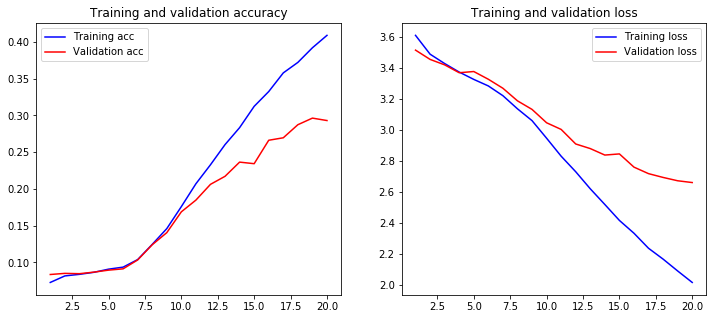

In [15]:
plot_history(history)

Using pretrained word embeddings